# Installing Required Dependencies And Importing Required Libraries

In [1]:
!pip install wandb
!pip install tensorflow
!pip install keras
import keras
import numpy as np
from keras.datasets import fashion_mnist
from tqdm.auto import tqdm
import tensorflow as tf
import wandb
import pprint

     |████████████████████████████████| 2.0MB 8.8MB/s 
     |████████████████████████████████| 133kB 56.8MB/s 
     |████████████████████████████████| 163kB 56.8MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=c31a706462f1a44916d53bf723db33bb4c8c6d5e6094a041b38b8bea2d55210e
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=577b41343766264010a87e461b6358366b816a3ae92b69bece0e3b84c12b6d85
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


**Logging Into wandb**

In [2]:
wandb.login(key='14394907543f59ea21931529e34b4d80d2ca8c9c')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Question 1

Logging sample images onto wandb.

In [3]:
# initializing wandb
wandb.init(project='fashion')

wandb: Currently logged in as: ramkamal (use `wandb login --relogin` to force relogin)


In [4]:
def load_fashion_mnist(return_images=False, test=False):
  '''
  Function which returns a dictionary containing the shuffled version of the fashion MNIST dataset.
  If test is True, only train and val are returned, should be interpreted as the train+val and test data.
  '''
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

  # shuffling data
  train_shuffler = np.random.shuffle(np.arange(60000))
  x_train, y_train = x_train[train_shuffler][0], y_train[train_shuffler][0]
  test_shuffler = np.random.shuffle(np.arange(10000))
  x_test, y_test = x_test[test_shuffler][0], y_test[test_shuffler][0]

  # normalizing the input data
  x_train = np.array(x_train/255).astype('float32')
  x_test = np.array(x_test/255).astype('float32')

  # partitioning the training data into train and val sets
  if test==False:
    x_train, x_val = x_train[:54000], x_train[54000:]
    y_train, y_val = y_train[:54000], y_train[54000:]

    if (return_images==False):
      return {
          'train': {
              'X': x_train.reshape([-1, 784]),
              'Y': y_train.reshape([54000])
          },
          'val': {
              'X': x_val.reshape([-1, 784]),
              'Y': y_val.reshape([6000])
          },
          'test': {
              'X': x_test.reshape([-1, 784]),
              'Y': y_test.reshape([10000])
          }
    }

    else :
      return {
        'train': {
              'X': x_train,
              'Y': y_train
        },
        'val': {
              'X': x_val,
              'Y': y_val
        },
        'test': {
              'X': x_test,
              'Y': y_test
        }
      }

  else:
    print('train = Old Train + Old Val', 'val = Old Test', sep='\n')
    return {
        'train': {
            'X': x_train.reshape([-1, 784]),
            'Y': y_train.reshape([60000])
        },
        'val': {
            'X': x_test.reshape([-1, 784]),
            'Y': y_test.reshape([10000])
        }
    }

data = load_fashion_mnist()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
def log_sample_images():
  '''
  Function to log sample images onto wandb.
  '''
  dataset = load_fashion_mnist(return_images=True)
  train_images = dataset['train']['X']
  train_labels = dataset['train']['Y']

  class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
  example_images, example_labels = [], []

  label_list = list(range(10))

  for (x, y) in zip(train_images, train_labels):
    if y in label_list:
      label_list.remove(y)
      example_images.append(x)
      example_labels.append(class_names[int(y)])
  
  wandb.log({"Example Images:": [wandb.Image(img, caption=caption) for img, caption in zip(example_images, example_labels)]})

log_sample_images()

# Question 2

Implementation of FF neural network and backpropograion.
The predict method returns $\hat{Y}$ which is the required probability distribution.

In [6]:
class neural_network:

  # constructor function - initializes weights
  def __init__(self, dict_layers, initializer):

    # initializing weights list
    self.weights_list = []
    self.biases_list = []
    self.dict_layers= dict_layers
    self.weights_list, self.biases_list = wandb_initializer(dict_layers, self.weights_list, self.biases_list, initializer)

  # function to compute forward propogation
  def forward_prop(self, W, b, X, Y, activation_func):
    '''
    This fuction implements forward propagation

      forward propagation :
      A_i = W_i*H_(i-1) + b_i
      H_i = activation_func(A_i)

      Output = softmax(A_L)

    Returns :
    Output (Y_hat) , A , H
    '''

    # initializing A and H lists
    A = []
    H = []
    
    # activation of layer 1
    H_pre = X
    
    # number of hidden layers
    L = self.dict_layers['num_hidden_layers']

    # forward propogration    
    for i in range(L) :

      # computing pre activation
      A.append(W[i] @ H_pre + b[i])

      # computing activation
      H_pre = getattr(activation, activation_func)(A[i])
      H.append(H_pre)
    
    # computing pre activation of last layer
    A.append(W[L] @ H_pre + b[L])
    
    # computing outputs of neural network
    Y_hat = activation.softmax(A[L])
    
    return {
        'A' : A,
        'H' : H,
        'Y_hat' : Y_hat
    }

  # helper function to perform forward propogation 
  def self_forward_prop(self, X, Y, activation_func) :

    temp = self.forward_prop(self.weights_list,self.biases_list, X, Y, activation_func)
    return temp

  # function to perform backward propogration
  def back_prop(self, W, b, A, H, Y_hat, X, Y,activation_func):
    '''
    This function implements backpropogation :
      
      Backprop :
      L = cross-entropy loss

      δL/δW_i = (δL/δA_i)(H_(i-1))
      δL/δb = δL/δA_i
      δL/δH_(i-1) = (W_i)^T(δL/δA)
      δL/δA_(i-1) = δL/δH_(i-1) ⊙ g'(H_(i-1))

    Inputs : Y_hat - Y predicted, Y - true Y , X - train data , A,H - from forward propogation

    Returns : δL/δW , δL/δb
    '''

    # batch size
    batch_size = len(Y)
    
    # initializing gradient lists
    del_w = []
    del_b = []
    L = self.dict_layers['num_hidden_layers']
    
    # converting ouputs to one hot vectors
    E = np.zeros(Y_hat.shape)
    E[Y,np.arange(batch_size)] = 1
    
    # gradient calculation for final layer
    grad_A = -(E - Y_hat)

    # iterating through layers
    for i in range(L,-1,-1) :

      temp1 = grad_A.reshape(-1,batch_size)
      
      if i==0 :
        temp2 = X.T
      else :
        temp2 = H[i-1].reshape((batch_size ,-1))

      # appending gradient vectors
      del_w.append(temp1 @ temp2/batch_size)
      del_b.append(grad_A/batch_size)

      # gradient calculation for all but last layers
      if(i!=0) :
        grad_H = W[i].T @ grad_A      
        grad_A = grad_H * getattr(activation,activation_func+'_der')(H[i-1])

    for j in range(len(del_b)) :
       del_b[j] = np.sum(del_b[j],axis=1)

    return {
        'dw' : del_w,
        'db' : del_b
    }

  # helper function to perform backward propogation
  def self_back_prop(self, A, H, Y_hat, X, Y,activation_func) :
    temp = self.back_prop(self.weights_list,self.biases_list, A, H, Y_hat, X, Y, activation_func)
    return temp

  #  function to compute gradient
  def grad_wandb(self, W, b, X, Y,activation_func):
    ''' 
    Function to find gradient of Cross entropy loss with respect to given W and b

    Arguments : W,B and data (X,Y)
    Returns : Returns : δL/δW , δL/δb
    '''

    # reshaping feature vector
    X = X.T.reshape((784,-1))
    
    # forward and backward propogation
    temp = self.forward_prop(W, b, X, Y, activation_func)
    temp2 = self.back_prop(W, b, temp['A'], temp['H'], temp['Y_hat'], X, Y, activation_func)

    return {
        'dw' : temp2['dw'],
        'db' : temp2['db']
    }

  # helper function to compute gradient
  def self_grad_wandb(self, X, Y, activation_func) :
    temp = self.grad_wandb(self.weights_list, self.biases_list, X, Y,activation_func)
    return temp

  # function to compute predictions
  def predict(self, X, activation_func):
    '''
    Function to take X and give the prediction of the network on this X
    '''

    # reshaping feature vector
    X = X.T.reshape((784,-1))
    temp = self.forward_prop(self.weights_list,self.biases_list, X, 0, activation_func)
    return {
      'Y' : np.argmax(temp['Y_hat'],axis=0),
      'Y_hat' : temp['Y_hat']
    }

  # function to update weights and biases
  def update_vals(self, dw, db, wd) :
    '''
    Functions to update parameters of the network
    Arguments : change in weights(dw) , change in biases (db) , Regularization parameter : wd
    '''
    L = len(self.weights_list)
    for i in range(L) :
      self.weights_list[i] =self.weights_list[i] - dw[L-i-1].reshape(self.weights_list[i].shape) - wd * self.weights_list[i]

    #for i in range(len(self.biases_list)) :
      self.biases_list[i] =self.biases_list[i] - db[L-i-1].reshape(self.biases_list[i].shape)  

# class containing activation functions and derivaties
class activation:
  
  @staticmethod
  def sigmoid(z):
    return 1 / (1 + np.exp(-z))
  
  @staticmethod
  def relu(z):
    return (z>0) * z

  @staticmethod
  def tanh(z):
    return np.tanh(z)

  @staticmethod
  def sigmoid_der(z) :
    return z * (1-z)
  
  @staticmethod
  def relu_der(z) :
    return (z>0)

  @staticmethod
  def tanh_der(z):
    return 1 - z*z

  @staticmethod
  def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x,axis=0)

# function to set shape of neural network
def set_nn_shape(verbose=True, num_hidden_layers=-1, hidden_layer_size=-1):

  input_layer_size = 784
  hidden_layer_size = hidden_layer_size
  num_hidden_layers = num_hidden_layers
  output_layer_size = 10
  
  if (verbose):
    print("\nNumber Of Hidden Layers:")
    num_hidden_layers = int(input())

    print("\nSize Of Each Hidden Layer:")
    hidden_layer_size = int(input())

    print(f"\nThe Neural Network Has {num_hidden_layers+2} Layers In Total!")
  
  return {"input_layer_size": input_layer_size, "hidden_layer_size": hidden_layer_size, "output_layer_size": output_layer_size, "num_hidden_layers": num_hidden_layers}


In [7]:
# function to initialize weights
def wandb_initializer(nn_shape, weights_list, biases_list, type='random', mu = 0, sigma = 1):
  
  # random initialization
  if (type=='random'):
    initializer = tf.keras.initializers.TruncatedNormal(mean=mu, stddev=sigma)
  
  # xavier initialization
  elif (type=='xavier'):
    initializer = tf.keras.initializers.GlorotNormal()

  weights_list.append(initializer(shape=(nn_shape['hidden_layer_size'], nn_shape['input_layer_size'])).numpy())
  biases_list.append(initializer(shape=(nn_shape['hidden_layer_size'], 1)).numpy())
  for i in range(nn_shape['num_hidden_layers'] - 1):
    weights_list.append(initializer(shape=(nn_shape['hidden_layer_size'], nn_shape['hidden_layer_size'])).numpy())
    biases_list.append(initializer(shape=(nn_shape['hidden_layer_size'], 1)).numpy())

  weights_list.append(initializer(shape=(nn_shape['output_layer_size'], nn_shape['hidden_layer_size'])).numpy())
  biases_list.append(initializer(shape=(nn_shape['output_layer_size'], 1)).numpy())

  return weights_list, biases_list

# Question 3

Class containing the different optimizers. To add a new optimizer just add and extra function in this class and maintain consistency with the inputs and the objects returned.

In [8]:
# class containing various optimizer functions
class optimizer:

  @staticmethod
  def sgd(network, data, config, logging=True):
    '''
    This function implements gradient descent
      Gradient descent :
      param = param - eta*δL/δparam

    '''
    #intializing values from config
    num_epochs, batch_size = config['num_epochs'], config['batch_size']
    eta, lambda_ = config['lr'], config['weight_decay']
    initializer, activation_func = config['weights_initializer'], config['activation']

    X_train, Y_train = data['train']['X'], data['train']['Y']
    num_examples = len(X_train)

    for i in range(num_epochs):
      for k in tqdm(range(0, len(X_train), batch_size)) :

        #X,Y for this iteration
        X = X_train[k: k+batch_size]
        Y = Y_train[k: k+batch_size]

        #calculate gradient
        temp = network.self_grad_wandb(X, Y, activation_func)         
        dw = temp['dw']
        db = temp['db']

        #multiply by eta
        for dd in dw :
          dd*= eta
        for dd in db :
          dd*=eta

        #update weights
        network.update_vals(dw, db, lambda_)
    
      report = run_callback(network, data, config)
      pprint.pprint(report) 
        
      if logging:  
        wandb.log({
              'batch_size': config['batch_size'], 
              'val_loss' : report['loss']['val'], 
              'train_loss': report['loss']['train'],
              'train_acc': report['accuracy']['train'],
              'val_acc': report['accuracy']['val']  
        }) 

    return {
        'batch_size': config['batch_size'], 
        'val_loss' : report['loss']['val'], 
        'train_loss': report['loss']['train'],
        'train_acc': report['accuracy']['train'],
        'val_acc': report['accuracy']['val']  
    }


  @staticmethod
  def momentum(network, data, config,gamma = 0.9, logging=True) :
    '''
    This function implements momentum based Gradient descent
     Momentum :
     update_t = gamma*update_(t-1) + eta*δL/δparam
     param = param - update_t

    '''
    #intializing values from config
    num_epochs, batch_size = config['num_epochs'], config['batch_size']
    eta, lambda_ = config['lr'], config['weight_decay']
    initializer, activation_func = config['weights_initializer'], config['activation']
    
    X_train, Y_train = data['train']['X'], data['train']['Y']
    num_examples = len(X_train)

    #initialize all momentum to zero
    nn_shape = set_nn_shape(False, config['num_hidden_layers'], config['hidden_layer_size'])
    dw, db = wandb_initializer(nn_shape, [], [], 'random', 0, 0)

    dw.reverse()
    db.reverse()

    for j in range(len(db)) :
      db[j] = db[j].flatten()

    for i in range(num_epochs) :
      for k in tqdm(range(0, len(X_train), batch_size)) :
        #X,Y for this iteration
        X = X_train[k:k+batch_size]
        Y = Y_train[k:k+batch_size]

        #calculate gradient
        temp = network.self_grad_wandb(X,Y,activation_func)  

        #add current gradient to previous stored momentum
        for j in range(len(dw)) :
          dw[j] += eta*temp['dw'][j]
          db[j] += eta*temp['db'][j]

        #update weights
        network.update_vals(dw,db, lambda_)

        #multiply by momentum gammma
        for dd in db :
          dd*=gamma
        for dd in dw :
          dd*=gamma

      report = run_callback(network, data, config)
      pprint.pprint(report) 
        
      if logging:  
        wandb.log({
              'batch_size': config['batch_size'], 
              'val_loss' : report['loss']['val'], 
              'train_loss': report['loss']['train'],
              'train_acc': report['accuracy']['train'],
              'val_acc': report['accuracy']['val']  
        }) 
    
    return {
        'batch_size': config['batch_size'], 
        'val_loss' : report['loss']['val'], 
        'train_loss': report['loss']['train'],
        'train_acc': report['accuracy']['train'],
        'val_acc': report['accuracy']['val']  
    }
        
  @staticmethod
  def NAG(network, data, config,gamma = 0.9, logging=True) :
    '''
    This function implements Nesterov Accelerated Gradient descent
     NAG :
     param_lookahead = param - gamma*upadte_(t-1)
     update_t = gamma*update_(t-1) + eta*δL/δparam_lookahead
     param = param - update_t

    '''
    #intializing values from config
    num_epochs, batch_size = config['num_epochs'], config['batch_size']
    eta, lambda_ = config['lr'], config['weight_decay']
    initializer, activation_func = config['weights_initializer'], config['activation']
    
    X_train, Y_train = data['train']['X'], data['train']['Y']
    
    #initialize momentums to zero
    nn_shape = set_nn_shape(False, config['num_hidden_layers'], config['hidden_layer_size'])
    v_dw, v_db = wandb_initializer(nn_shape, [], [], 'random', 0, 0)
    v_dw.reverse()
    v_db.reverse()
    for j in range(len(v_db)) :
      v_db[j] = v_db[j].flatten()
    

    for i in range(num_epochs) :
      for k in tqdm(range(0, len(X_train), batch_size)) :
        
        #multiply previous momentum with gammma
        for j in range(len(v_dw)) :
          v_dw[j] = gamma*v_dw[j]
          v_db[j] = gamma*v_db[j]

        #X,Y for this iteration
        X = X_train[k:k+batch_size]
        Y = Y_train[k:k+batch_size]
        
        #lookahead parameters
        W = network.weights_list.copy()
        B = network.biases_list.copy()
        L = len(W)
        for j in range(L) :
          W[j] -= v_dw[L-j-1]
          B[j] -= v_db[L-j-1].reshape(B[j].shape)

        #calculate gradient with respect to lookahead parameter
        temp = network.grad_wandb(W,B,X,Y,activation_func)  

        #add current gradient to stored momentum
        for j in range(len(v_dw)) :
          v_dw[j] += eta*temp['dw'][j]
          v_db[j] += eta*temp['db'][j]

        #update weights
        network.update_vals(v_dw,v_db,lambda_)

      report = run_callback(network, data, config)
      pprint.pprint(report) 
        
      if logging:  
        wandb.log({
              'batch_size': config['batch_size'], 
              'val_loss' : report['loss']['val'], 
              'train_loss': report['loss']['train'],
              'train_acc': report['accuracy']['train'],
              'val_acc': report['accuracy']['val']  
        }) 
      
    return {
        'batch_size': config['batch_size'], 
        'val_loss' : report['loss']['val'], 
        'train_loss': report['loss']['train'],
        'train_acc': report['accuracy']['train'],
        'val_acc': report['accuracy']['val']  
    }


  @staticmethod
  def RMSprop(network, data, config,beta = 0.9,epsilon = 1e-8, logging=True) :
    '''
    This function implements RMS prop
     RMSprop :
     v_t = beat*v_(t-1) + (1-beta)*(δL/δparam)**2
     param = param - (eta/sqrt(epsilon + v_t))*δL/δparam

    '''
    #intializing values from config
    num_epochs, batch_size = config['num_epochs'], config['batch_size']
    eta, lambda_ = config['lr'], config['weight_decay']
    initializer, activation_func = config['weights_initializer'], config['activation']
    
    X_train, Y_train = data['train']['X'], data['train']['Y']
    num_examples = len(X_train)

    #initialize prev_update values to zero
    nn_shape = set_nn_shape(False, config['num_hidden_layers'], config['hidden_layer_size'])
    v_dw, v_db = wandb_initializer(nn_shape, [], [], 'random', 0, 0)
    v_dw.reverse()
    v_db.reverse()
    for j in range(len(v_db)) :
      v_db[j] = v_db[j].flatten()

    for i in range(num_epochs) :
      dw = []
      db = []
      for k in tqdm(range(0, len(X_train), batch_size)) :

        #X,Y for this iteration
        X = X_train[k:k+batch_size]
        Y = Y_train[k:k+batch_size]

        #calculate gradient
        temp = network.self_grad_wandb(X,Y,activation_func)  

        dw = temp['dw']
        db = temp['db']

        for j in range(len(dw)) :
          #add current dw*dw to stored value
          v_dw[j] *= beta
          v_dw[j] += (1-beta)*(dw[j]**2)
          #new dw value
          dw[j] *= eta/np.sqrt(v_dw[j]+epsilon)

          #add current db*db to stored value
          v_db[j] *= beta
          v_db[j] += (1-beta)*(db[j]**2) 
          #new db value
          db[j] *= eta/np.sqrt(v_db[j]+epsilon)

        #update weights
        network.update_vals(dw,db, lambda_)

      report = run_callback(network, data, config) 
      pprint.pprint(report)

      if logging:  
        wandb.log({
              'batch_size': config['batch_size'], 
              'val_loss' : report['loss']['val'], 
              'train_loss': report['loss']['train'],
              'train_acc': report['accuracy']['train'],
              'val_acc': report['accuracy']['val']  
        }) 
      
    return {
        'batch_size': config['batch_size'], 
        'val_loss' : report['loss']['val'], 
        'train_loss': report['loss']['train'],
        'train_acc': report['accuracy']['train'],
        'val_acc': report['accuracy']['val']  
    }


  @staticmethod
  def adam(network, data, config, beta1=0.9, beta2=0.999, epsilon=1e-8, logging=True):
    '''
    This function implements Adam
    Adam is similar to RMS prop,but with momentum

    '''
    #intializing values from config
    num_epochs, batch_size = config['num_epochs'], config['batch_size']
    eta, lambda_ = config['lr'], config['weight_decay']
    initializer, activation_func = config['weights_initializer'], config['activation']
 
   
    X_train, Y_train = data['train']['X'], data['train']['Y']
    num_examples = len(X_train)

    #initialize values to zero
    nn_shape = set_nn_shape(False, config['num_hidden_layers'], config['hidden_layer_size'])
    m_w, m_b = wandb_initializer(nn_shape, [], [], 'random', 0, 0)
    v_w, v_b = wandb_initializer(nn_shape, [], [], 'random', 0, 0)
    m_w.reverse()
    m_b.reverse()
    v_w.reverse()
    v_b.reverse()
    for j in range(len(m_b)):
      m_b[j], v_b[j] = m_b[j].flatten(), v_b[j].flatten() 
    
    # t is number of updates
    t = 0

    eta = eta/(1-beta1)

    for i in range(num_epochs):
      for k in tqdm(range(0, len(X_train), batch_size)) :
        
        t += 1

        #X,Y for this iteration        
        X = X_train[k: k+batch_size]
        Y = Y_train[k: k+batch_size]
        
        #calculate gradient
        temp = network.self_grad_wandb(X, Y, activation_func)
        
        dw = temp['dw']
        db = temp['db']
        
        for j in range(len(dw)):
          # update with current dw
          m_w[j] = beta1 * m_w[j] + (1 - beta1) * dw[j]
          m_b[j] = beta1 * m_b[j] + (1 - beta1) * db[j]
          # update with current db
          v_w[j] = beta2 * v_w[j] + (1 - beta2) * dw[j] * dw[j]
          v_b[j] = beta2 * v_b[j] + (1 - beta2) * db[j] * db[j]
                 
          #divide by (1-beta**t) for bias correction
          m_w_hat = m_w[j] *((1-beta1)/ (1-beta1**int(t+1)))
          m_b_hat = m_b[j] *((1-beta1)/ (1-beta1**int(t+1)))
          
          v_w_hat = v_w[j]*((1-beta2)/ (1-beta2**int(t+1)))
          v_b_hat = v_b[j]*((1-beta2)/ (1-beta2**int(t+1)))
          
          #new dw,db
          dw[j] = eta * m_w_hat / (epsilon + np.sqrt( v_w_hat))
          db[j] = eta * m_b_hat / ( epsilon + np.sqrt(v_b_hat))

        #update weights 
        network.update_vals(dw, db, lambda_)
        
      report = run_callback(network, data, config)
      pprint.pprint(report) 
        
      if logging:  
        wandb.log({
              'batch_size': config['batch_size'], 
              'val_loss' : report['loss']['val'], 
              'train_loss': report['loss']['train'],
              'train_acc': report['accuracy']['train'],
              'val_acc': report['accuracy']['val']  
        }) 
      
    return {
        'batch_size': config['batch_size'], 
        'val_loss' : report['loss']['val'], 
        'train_loss': report['loss']['train'],
        'train_acc': report['accuracy']['train'],
        'val_acc': report['accuracy']['val']  
    }

    
  @staticmethod
  def nadam(network, data, config, beta1=0.9, beta2=0.999, epsilon=1e-8, logging=True):
    '''
    This function implements Nadam.
    Just like Adam is RMS prop with momentum,
    Nadam is RMS prop with Nesterov

    '''
    #intializing values from config
    num_epochs, batch_size = config['num_epochs'], config['batch_size']
    eta, lambda_ = config['lr'], config['weight_decay']
    initializer, activation_func = config['weights_initializer'], config['activation']
 
    X_train, Y_train = data['train']['X'], data['train']['Y']
    num_examples = len(X_train)
    
    #initialize values to zero
    nn_shape = set_nn_shape(False, config['num_hidden_layers'], config['hidden_layer_size'])
    m_w, m_b = wandb_initializer(nn_shape, [], [], 'random', 0, 0)
    v_w, v_b = wandb_initializer(nn_shape, [], [], 'random', 0, 0)
    m_w.reverse()
    m_b.reverse()
    v_w.reverse()
    v_b.reverse()
    for j in range(len(m_b)):
      m_b[j], v_b[j] = m_b[j].flatten(), v_b[j].flatten() 
    
    # t is number of updates
    t = 0
    eta = eta/(1-beta1)
    for i in range(num_epochs):
      for k in tqdm(range(0, len(X_train), batch_size)) :
        
        t += 1
        
        #X,Y for this iteration
        X = X_train[k: k+batch_size]
        Y = Y_train[k: k+batch_size]
        
        #calculate gradient
        temp = network.self_grad_wandb(X, Y, activation_func)
        
        dw = temp['dw']
        db = temp['db']
        
        for j in range(len(dw)):
          # update with current dw
          m_w[j] = beta1 * m_w[j] + (1 - beta1) * dw[j]
          m_b[j] = beta1 * m_b[j] + (1 - beta1) * db[j]
          # update with current db
          v_w[j] = beta2 * v_w[j] + (1 - beta2) * dw[j] * dw[j]
          v_b[j] = beta2 * v_b[j] + (1 - beta2) * db[j] * db[j]
                 
          #divide by (1-beta**t) for bias correction
          m_w_hat = m_w[j] *((1-beta1)/ (1-beta1**int(t+1)))
          m_b_hat = m_b[j] *((1-beta1)/ (1-beta1**int(t+1)))
          
          v_w_hat = v_w[j]*((1-beta2)/ (1-beta2**int(t+1)))
          v_b_hat = v_b[j]*((1-beta2)/ (1-beta2**int(t+1)))
          
          #new dw,db
          dw[j] = eta * (beta1*m_w_hat + (1 - beta1)*dw[j]) / (epsilon + np.sqrt( v_w_hat))
          db[j] = eta * (beta1*m_b_hat + (1 - beta1)*db[j]) / ( epsilon + np.sqrt(v_b_hat))
        
        #update weights
        network.update_vals(dw, db, lambda_)
        
      report = run_callback(network, data, config) 
      pprint.pprint(report)

      if logging:  
        wandb.log({
              'batch_size': config['batch_size'], 
              'val_loss' : report['loss']['val'], 
              'train_loss': report['loss']['train'],
              'train_acc': report['accuracy']['train'],
              'val_acc': report['accuracy']['val']  
        }) 
      
    return {
        'batch_size': config['batch_size'], 
        'val_loss' : report['loss']['val'], 
        'train_loss': report['loss']['train'],
        'train_acc': report['accuracy']['train'],
        'val_acc': report['accuracy']['val']  
    }


In [9]:
# callback function used to compute losses and accuracies
def run_callback(network, data, config) :
    
    # activation function
    activation_func = config['activation']
    
    # getting the training data
    X_train = data['train']['X']
    Y_train = data['train']['Y']

    # getting the validation data
    X_val = data['val']['X']
    Y_val = data['val']['Y']

    # initializing 
    train_loss = 0
    train_count = 0
    train_sq_error = 0
    
    # predicting outputs
    temp = network.predict(X_train, activation_func)
    
    # counting number of correct guesses
    train_count = np.sum(temp['Y'].reshape(Y_train.shape)==Y_train)
    
    # softmax predictions
    Y_pred = np.array(temp['Y_hat'].T)

    # computing cross entropy loss
    train_loss = np.sum(-np.log(Y_pred[np.arange(len(X_train)),Y_train]))
    
    # converting output to one hot vectors
    E = np.zeros(Y_pred.shape)
    E[np.arange(len(X_train)),Y_train] = 1
    
    # computing squared error loss
    train_sq_error = np.sum((E-Y_pred)**2)

    # initializing
    val_loss = 0
    val_count = 0
    val_sq_error = 0
    
    # predicting outputs
    temp = network.predict(X_val, activation_func)

    # counting number of correct guesses
    val_count = np.sum(temp['Y'].reshape(Y_val.shape)==Y_val)
    
    # softmax predictions
    Y_pred = np.array(temp['Y_hat'].T)
    val_loss = np.sum(-np.log(Y_pred[np.arange(len(X_val)),Y_val]))
    
    # converting output to one hot vectors    
    E = np.zeros(Y_pred.shape)
    E[np.arange(len(X_val)),Y_val] = 1

    # computing squared error loss
    val_sq_error = np.sum((E-Y_pred)**2)
    
    return  {
        'loss': {
            'train' : train_loss / len(X_train),
            'val' : val_loss / len(X_val)
        },
        'accuracy': {
            'train': train_count / len(X_train),
            'val': val_count / len(X_val)
        }
    }

    


# Question 4

Performing the sweep. Find the parameters dictionary below.

In [10]:
# sweep configuration
sweep_config = {
    'method' : 'bayes',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
     } ,

    'parameters': {
        'num_epochs': {
            'values': [5, 10]
        },
        'num_hidden_layers': {
            'values': [3, 4, 5]
        },
        'hidden_layer_size': {
            'values': [32, 64, 128, 256]
        },
        'weight_decay': {
            'values': [0.5, 0.05, 0.005, 0.0005, 0]
        },
        'lr': {
            'values': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'NAG', 'RMSprop', 'adam', 'nadam']
        },
        'batch_size': {
            'values': [64, 32, 16]
        },
        'weights_initializer': {
            'values': ['random', 'xavier']
        },
        'activation': {
            'values': ['sigmoid', 'tanh', 'relu']
        }        
    }
}


In [11]:
# generating sweep id
sweep_id = wandb.sweep(sweep_config, project='fashion_mnist_final_2')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 8spm6pb9
Sweep URL: https://wandb.ai/ramkamal/fashion_mnist_final_2/sweeps/8spm6pb9


In [12]:
pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'activation': {'values': ['sigmoid', 'tanh', 'relu']},
                'batch_size': {'values': [64, 32, 16]},
                'hidden_layer_size': {'values': [32, 64, 128, 256]},
                'lr': {'values': [1e-07, 1e-06, 1e-05, 0.0001, 0.001]},
                'num_epochs': {'values': [5, 10]},
                'num_hidden_layers': {'values': [3, 4, 5]},
                'optimizer': {'values': ['sgd',
                                         'momentum',
                                         'NAG',
                                         'RMSprop',
                                         'adam',
                                         'nadam']},
                'weight_decay': {'values': [0.5, 0.05, 0.005, 0.0005, 0]},
                'weights_initializer': {'values': ['random', 'xavier']}}}


In [13]:
# function to train the model
class sweep_module:
  @staticmethod
  def train(config=None):

    with wandb.init(config):
      
      # making a local copy of config
      config = wandb.config

      #overwriting run name
      wandb.run.name = 'ac:'+config['activation'][:3]+'_opt:'+config['optimizer'][:4]+'_hl:'+str(config['num_hidden_layers'])+':'+str(config['hidden_layer_size'])
      
      # setting shape of neural network
      nn_shape = set_nn_shape(False, config['num_hidden_layers'] , config['hidden_layer_size'])
      
      # initializing the neural network
      network = neural_network(nn_shape, config['weights_initializer'])
      
      # calling the optimizer
      getattr(optimizer, config['optimizer'])(network, data, config)

In [14]:
# performing the sweep
wandb.agent(sweep_id, sweep_module.train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: ej8k0i0r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hidden_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weights_initializer: xavier



{'accuracy': {'train': 0.8399629629629629, 'val': 0.8258333333333333},
 'loss': {'train': 0.47562157045454917, 'val': 0.49285369386686256}}


wandb: Ctrl + C detected. Stopping sweep.


# Question 7

Retraining the model with the best hyperparameters found earlier. 

In [ ]:
def train(config=None):
  '''
  Training one final model with the best hyperparamters.  
  '''
  
  # setting shape of neural network
  nn_shape = set_nn_shape(False, config['num_hidden_layers'] , config['hidden_layer_size'])
      
  # initializing the neural network
  network = neural_network(nn_shape, config['weights_initializer'])
      
  # calling the optimizer
  report = getattr(optimizer, config['optimizer'])(network, data, config, logging=False)

  return network, report

In [ ]:
data = load_fashion_mnist(return_images = False, test=True)

train = Old Train + Old Val
val = Old Test


**Refer To wandb Sweep Page To Figure Out Best Performing Model**

In [ ]:
config = {
    'num_epochs' : 10,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : 256,
    'weight_decay' : 0,
    'lr' : 1e-5,
    'optimizer' : 'nadam',
    'batch_size' : 16,
    'weights_initializer' : 'xavier',
    'activation' : 'sigmoid',
}

In [ ]:
network, report = train(config)


{'accuracy': {'train': 0.78825, 'val': 0.775},
 'loss': {'train': 0.65945398539131, 'val': 0.680305623338733}}



{'accuracy': {'train': 0.8517333333333333, 'val': 0.8359},
 'loss': {'train': 0.44672555461161295, 'val': 0.48417044713382057}}



{'accuracy': {'train': 0.8684833333333334, 'val': 0.8494},
 'loss': {'train': 0.38240701543962813, 'val': 0.4325011342274663}}



{'accuracy': {'train': 0.8773333333333333, 'val': 0.8573},
 'loss': {'train': 0.3507978685918019, 'val': 0.41002583068499}}



{'accuracy': {'train': 0.8844333333333333, 'val': 0.8626},
 'loss': {'train': 0.3288660838940715, 'val': 0.39845239942042765}}



{'accuracy': {'train': 0.88905, 'val': 0.8667},
 'loss': {'train': 0.31265263991803216, 'val': 0.39285230076850725}}



{'accuracy': {'train': 0.8921333333333333, 'val': 0.8671},
 'loss': {'train': 0.3034880361325554, 'val': 0.3930333124812902}}



{'accuracy': {'train': 0.8955, 'val': 0.8692},
 'loss': {'train': 0.2905593053424238, 'val': 0.3896699703645221}}



{'accuracy': {'train': 0.9008, 'val': 0.8717},
 'loss': {'train': 0.2745269348382756, 'val': 0.385032372994577}}



{'accuracy': {'train': 0.9043166666666667, 'val': 0.872},
 'loss': {'train': 0.2633328608719418, 'val': 0.38744153705314244}}


In [ ]:
print('Test Accuracy: {}'.format(report['val_acc']))

Test Accuracy: 0.872


# Question 7

Plotting the confusion matrix for the best trained model on the test set.

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
X = data['val']['X']
Y_true = data['val']['Y']
Y_pred = network.predict(X, config['activation'])['Y']

## Plotting Confusion Matrix

In [ ]:
cf_mat = confusion_matrix(Y_true, Y_pred)
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'] 
df_cf = pd.DataFrame(data=cf_mat, index=class_names, columns=class_names)
df_cf.index.name, df_cf.columns.name = 'True Label', 'Predicted Label'

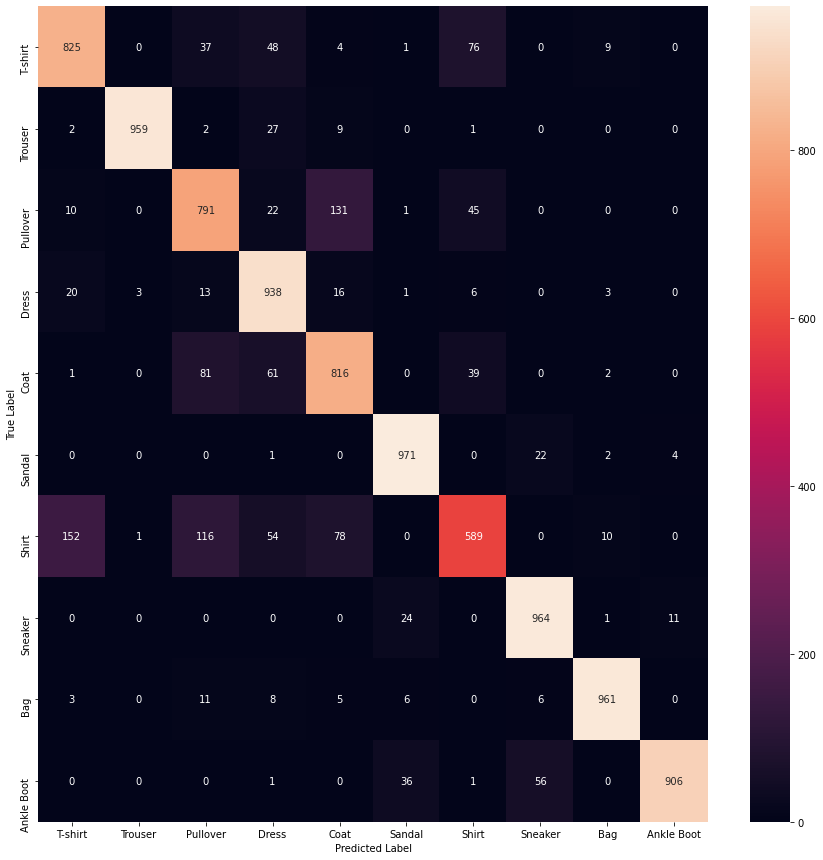

In [ ]:
plt.figure(figsize=(15, 15))
fig1 = sns.heatmap(df_cf, annot=True, fmt='g')
plt.show()

In [ ]:
cf_mat = confusion_matrix(Y_true, Y_pred)
cf_mat = (cf_mat > 50) * cf_mat
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'] 
df_cf = pd.DataFrame(data=cf_mat, index=class_names, columns=class_names)
df_cf.index.name, df_cf.columns.name = 'True Label', 'Predicted Label'

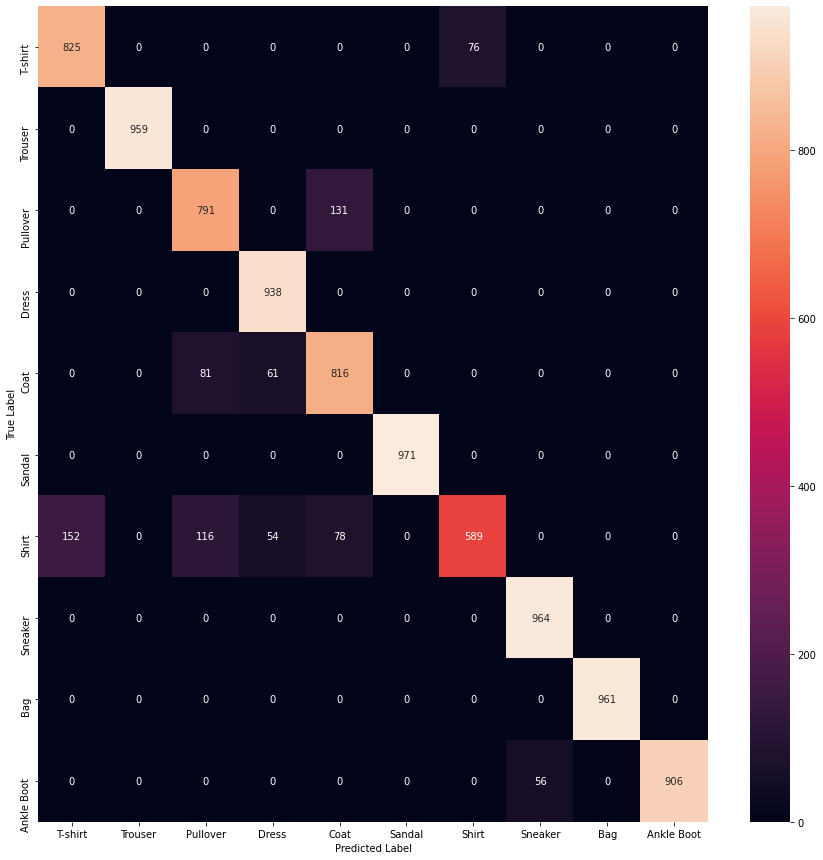

In [ ]:
plt.figure(figsize=(15, 15))
fig2 = sns.heatmap(df_cf, annot=True, fmt='g')
plt.show()

In [ ]:
cf_mat = confusion_matrix(Y_true, Y_pred)
# 50 is arbitrarily chosen based on the most recent run
cf_mat_thresh = (cf_mat > 50) * cf_mat
np.fill_diagonal(cf_mat_thresh, 0)
cf_mat_thresh = cf_mat_thresh / np.sum(cf_mat)
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'] 
df_cf = pd.DataFrame(data=cf_mat_thresh, index=class_names, columns=class_names)
df_cf.index.name, df_cf.columns.name = 'True Label', 'Predicted Label'

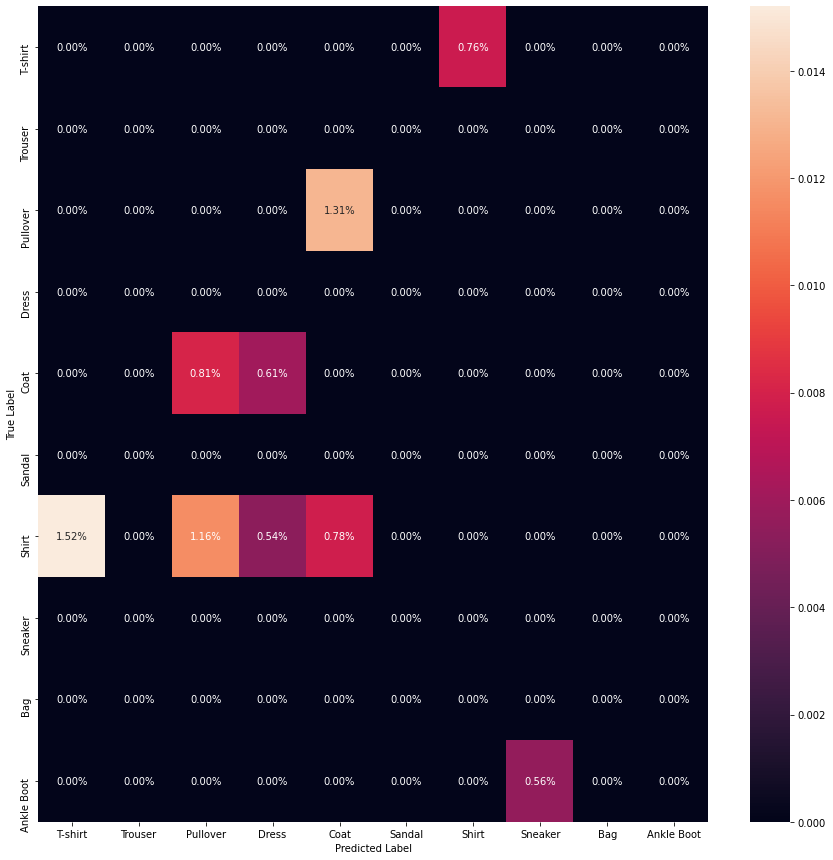

In [ ]:
plt.figure(figsize=(15, 15))
fig3 = sns.heatmap(df_cf, annot=True, fmt='.2%')
plt.show()

In [ ]:
# 9 and 12.8 are chosen arbitrarily based on the most recent run
print(f'9 Of The Misclassification Possibilities Account For {np.sum(cf_mat_thresh) * 100:.2f}% Out Of 12.8% Error')

6 Of The Misclassification Possibilities Account For 8.05% Out Of 12.8% Error


In [ ]:
images = [fig1, fig2, fig3]
labels = ['Raw Confusion Matrix', 'Thresholded Confusion Matrix', 'Major Misclassifications']
wandb.log({'Confusion Matrix': [wandb.Image(img, caption=caption) for img, caption in zip(images, labels)]})